# Load all datasets from raw data files and pickle conveniently

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
from scipy import io
import matplotlib
from scipy import sparse

# This file is from https://github.com/berenslab/rna-seq-tsne
import rnaseqTools

## Scala et al. 2019 (L4 data)

Number of cells: 118
Number of genes: 26514

(102, 17657)

['ADP (mV)' 'AHP (mV)' 'AI' 'AP amplitude (mV)' 'AP threshold (mV)'
 'AP width (ms)' 'Max number of spikes' 'Input R (MOhm)' 'Vm (mV)'
 'Latency (ms)' 'Rheobase (pA)' 'Sag ratio' 'Tau (ms)']
13

Chosen offset: 7.08


<IPython.core.display.Javascript object>


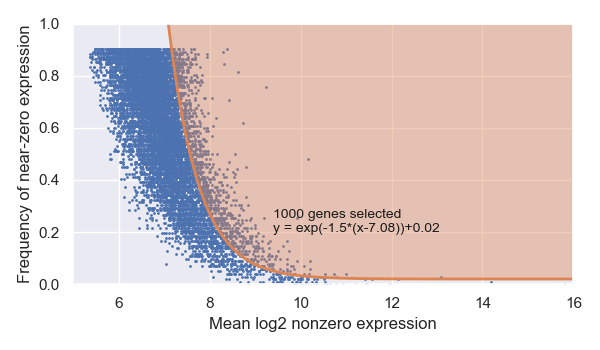

In [3]:
data = pd.read_csv('data/scala2019/patch-seq-counts.csv', sep='\t')
counts = data.values[:,1:].transpose().astype(float)
genes = data.values[:,0]
cells = np.array(data.columns[1:])

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))

meta = pd.read_excel('data/scala2019/layer4-cells.xlsx', index_col=0)
d = [d[6:10]+d[:2]+d[3:5] for d in meta.values[1:,1] if d is not np.nan]
s = [s[7:].strip() if 'sample ' in s else s[6:].strip() for s in meta.values[1:,2] if s is not np.nan]
names = [d[i]+'_sample_'+s[i] for i in range(len(d))]
regions = [m for m in meta.values[1:,3] if m=='V1' or m=='S1']
layers = [m for m in meta.values[1:,4] if ~np.isnan(m)]
names2regions = dict(zip(names,regions))
names2layers = dict(zip(names,layers))

regions = np.array([names2regions['_'.join(c.split('_')[:3])] for c in cells])
layers  = np.array([names2layers['_'.join(c.split('_')[:3])] for c in cells])

ephysData = pd.read_csv('data/scala2019/patch-seq-ephys-features.csv')
ephysNames = np.array(ephysData.columns[1:-2])
ephysCells = np.array([s.split('sample')[0]+'_sample_'+s.split('sample')[1] for s in ephysData.values[:,0]])
keep = ephysData['Good quality']
ai0 = ephysData['AI']==0
ephysData = ephysData.values[:, 1:-2].astype('float')
ephysData[~keep,:] = np.nan
ephysData[keep, ephysNames=='Latency (ms)'] = np.log(ephysData[keep, ephysNames=='Latency (ms)'])
ephysData[keep & ~ai0, ephysNames=='AI'] = np.log(ephysData[keep & ~ai0, ephysNames=='AI']/100)
ephysData[ai0, ephysNames=='AI'] = np.nan
names2ephys = dict(zip(ephysCells, ephysData))
ephys = np.array([names2ephys['_'.join(c.split('_')[:3])] if '_'.join(c.split('_')[:3]) in names2ephys
          else np.ones(ephysNames.size)*np.nan for c in cells]).astype(float)

# cells to exclude based on RNA (either low quality or maps to PV/excitatory
exclude = ['20180605_sample_12_L4_S109', '20180626_sample_11_L4_S129',
           '20180703_sample_6_L4_S157', '20180919_sample_21_L4_S136',
           '20180605_sample_17_L4_S114', '20180626_sample_7_L4_S125',
           '20180627_sample_1_L4_S137', '20180703_sample_4_L4_S154']

selection = ~np.isin(cells, exclude) & ~np.isnan(np.sum(ephys, axis=1))
counts = counts[selection, :]
cells = cells[selection]
ephys = ephys[selection,:]
regions = regions[selection]
layers = layers[selection]

g = np.sum(counts>0, axis=0)>0
counts = counts[:, g]
genes = genes[g]

print('')
print(counts.shape)

print('')
print(ephysNames)
print(ephysNames.size)

print('')
mostVariableGenes = rnaseqTools.geneSelection(counts, n=1000, threshold=32)

In [4]:
shortEphysLabels = {'ADP (mV)': 'ADP',
                    'AHP (mV)': 'AHP',
                    'AI': 'AI',
                    'AP amplitude (mV)': 'AP amp',
                    'AP threshold (mV)': 'AP thesh',
                    'AP width (ms)': 'AP width',
                    'Max number of spikes': 'Max AP num',
                    'Input R (MOhm)': 'R_input',
                    'Vm (mV)': 'V_rest',
                    'Latency (ms)': 'Latency',
                    'Rheobase (pA)': 'Rheobase',
                    'Sag ratio': 'Sag',
                    'Tau (ms)': 'Tau'}

ephysNames = [shortEphysLabels[e] for e in ephysNames]

patchseqdata = {'counts': sparse.csr_matrix(counts), 
                'cells': cells, 
                'genes': genes, 
                'regions': regions, 
                'layers': layers, 
                'ephys': ephys,
                'ephysNames': ephysNames,
                'mostVariableGenes': mostVariableGenes}

pickle.dump(patchseqdata, open('data/scala2019.pickle', 'wb'))

## Cadwell et al. 2016 (L1 data)

In [2]:
data = pd.read_excel('data/cadwell2016/Data_CortexInterneurons.xlsx', sheet_name="readcounts")
cells  = np.array([int(c[5:-1]) for c in data.values[2,2:-5]])
genes  = np.array([c[1:-1] for c in data.values[4:,1]])
counts = data.values[4:,2:-5].T.astype('float')

print('Number of cells: {}\nNumber of genes: {}\n'.format(counts.shape[0], counts.shape[1]))

# https://media.nature.com/original/nature-assets/nbt/journal/v34/n2/extref/nbt.3445-S3.xlsx
varGenes = pd.read_excel('data/cadwell2016/nbt.3445-S3.xlsx')
varGenes = varGenes.values[3:,-1]
varGenes = np.array([g[1:-1] for g in varGenes])
lgenes = list(genes)
counts = counts[:, [lgenes.index(g) for g in varGenes]]

from scipy import io
mat = io.loadmat('data/cadwell2016/IntPhysiologyFinal.mat')
types = np.array([mat['cell'][0][n][3][0][0] for n in range(len(mat['cell'][0]))])
idxs  = np.array([mat['cell'][0][n][0][0][0] for n in range(len(mat['cell'][0]))])

cols = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
ephysNames = np.array(['V_rest', 'R_input', 'AP tau', 'AP thresh', 'AP width', 'AP amp', 'AHP', 'ADP', 
                   'Adapt', 'ifDelayed', 'ifBurst'])
ephys = np.zeros((idxs.size, len(cols)))
for j,c in enumerate(cols):
    ephys[:,j] = [mat['cell'][0][i][c][0][0] for i in range(len(mat['cell'][0]))]

# Int_44 and Int_45 were removed from the Cadwell et al. due to possible contamination
keep = (idxs != 44) & (idxs != 45) & ~np.isnan(np.sum(ephys,axis=1))
types = types[keep]
idxs  =  idxs[keep]
ephys = ephys[keep]
counts = counts[[np.where(cells==i)[0][0] for i in idxs], :]

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))
print('Number of detected genes: {}'.format(np.sum(np.sum(counts>0, axis=0)>0)))
print('')
print(ephysNames)
print(ephysNames.size)

mostVariableGenes = np.zeros(varGenes.size).astype(bool)
mostVariableGenes[:3000] = True

patchseqdata = {'counts': sparse.csr_matrix(counts),
                'ephys': ephys, 
                'cellTypes': types,
                'ephysNames': ephysNames, 
                'genes': varGenes,
                'mostVariableGenes': mostVariableGenes}

pickle.dump(patchseqdata, open('data/cadwell2016.pickle', 'wb'))

Number of cells: 62
Number of genes: 21812

Number of cells: 44
Number of genes: 15074
Number of detected genes: 15054

['V_rest' 'R_input' 'AP tau' 'AP thresh' 'AP width' 'AP amp' 'AHP' 'ADP'
 'Adapt' 'ifDelayed' 'ifBurst']
11


## Scala et al. 2020 (M1 data)

In [2]:
# META DATA

meta = pd.read_csv('data/scala2020/mini-atlas-meta-data.csv', sep='\t')

cells = meta['Cell'].values

exclude = meta['Exclusion reasons'].values.astype(str)
exclude[exclude=='nan'] = ''

ttype = meta['RNA type'].values.astype(str)
ttype[ttype=='nan'] = ''

In [3]:
# TRANSCRIPTOMIC DATA: read counts

data = pd.read_csv('data/scala2020/final_patch_seq_allcells_exon_allreads.txt.zip', 
                   sep='\t', na_filter=False, index_col=0)
d = data.values.transpose()
counts = np.round(d.astype('float')).astype(int)
counts = sparse.csr_matrix(counts)
cellsRNA = np.array(data.columns)
genes = np.array(data.index)

print('Count matrix shape:', counts.shape)

# Match the order to the spreadsheet
reorder = [np.where(cellsRNA==c)[0][0] for c in cells]
counts = counts[reorder,:]

Count matrix shape: (1320, 42184)


In [4]:
# EPHYS DATA

ephysData = pd.read_csv('data/scala2020/Cell_Features_M1.csv')
ephysNames = np.array(ephysData.columns[2:]).astype(str)
ephysCells = ephysData.values[:,1]
ephysCells = [e.split('/')[-1][:-4] for e in ephysCells]
ephysCells = [e[6:10]+e[:2]+e[3:5]+'_sample_'+e.split()[-1] for e in ephysCells]
ephysData = ephysData.values[:,2:].astype('float')
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array([names2ephys[c] if c in names2ephys else ephysData[0]*np.nan for c in cells])

print('Number of cells with ephys data:', np.sum(np.isin(cells, ephysCells)))

Number of cells with ephys data: 1319


In [5]:
features_exclude = ['Afterdepolarization (mV)', 'AP Fano factor', 'ISI Fano factor', 
                    'Latency (ms)', 'Wildness', 'Spike frequency adaptation',
                    'Sag area (mV*s)', 'Sag time (s)', 'Burstiness',
                    'AP amplitude average adaptation index', 'ISI average adaptation index',
                    'Rebound number of APs']
features_log =     ['AP coefficient of variation', 'ISI coefficient of variation', 'ISI adaptation index']

for e in features_log:
    ephysData[:, ephysNames==e] = np.log(ephysData[:, ephysNames==e])
ephysData = ephysData[:, ~np.isin(ephysNames, features_exclude)]
ephysNames = ephysNames[~np.isin(ephysNames, features_exclude)]

In [6]:
selection = ~np.isnan(np.sum(ephysData, axis=1)) & (exclude=='') & (ttype!='')
counts = counts[selection, :]
cells = cells[selection]
ephysData = ephysData[selection, :]
ttype = ttype[selection]

print(counts.shape)
print(ephysData.shape)

(1213, 42184)
(1213, 16)


Chosen offset: 7.59


<IPython.core.display.Javascript object>


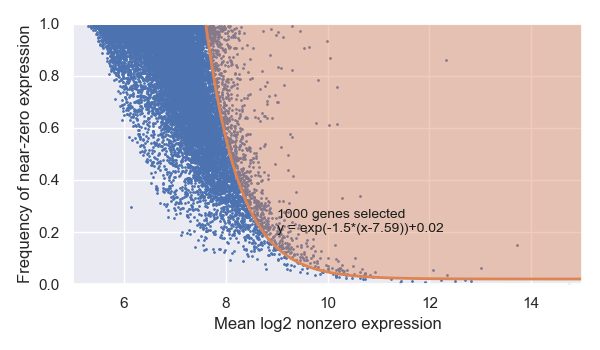

In [7]:
mostVariableGenes = rnaseqTools.geneSelection(counts, n=1000, threshold=32, decay=1.5)

In [8]:
clusterNames = ['Lamp5 Pax6', 'Lamp5 Egln3_1', 'Lamp5 Egln3_2', 'Lamp5 Egln3_3',
       'Lamp5 Pdlim5_1', 'Lamp5 Pdlim5_2', 'Lamp5 Slc35d3', 'Lamp5 Lhx6',
       'Sncg Col14a1', 'Sncg Slc17a8', 'Sncg Calb1_1', 'Sncg Calb1_2',
       'Sncg Npy2r', 'Vip Sncg', 'Vip Serpinf1_1', 'Vip Serpinf1_2',
       'Vip Serpinf1_3', 'Vip Htr1f', 'Vip Gpc3', 'Vip C1ql1',
       'Vip Mybpc1_1', 'Vip Mybpc1_2', 'Vip Mybpc1_3', 'Vip Chat_1',
       'Vip Chat_2', 'Vip Igfbp6_1', 'Vip Igfbp6_2', 'Sst Chodl',
       'Sst Penk', 'Sst Myh8_1', 'Sst Myh8_2', 'Sst Myh8_3', 'Sst Htr1a',
       'Sst Etv1', 'Sst Pvalb Etv1', 'Sst Crhr2_1', 'Sst Crhr2_2',
       'Sst Hpse', 'Sst Calb2', 'Sst Pvalb Calb2', 'Sst Pappa',
       'Sst C1ql3_1', 'Sst C1ql3_2', 'Sst Tac2', 'Sst Th_1', 'Sst Th_2',
       'Sst Th_3', 'Pvalb Gabrg1', 'Pvalb Egfem1', 'Pvalb Gpr149',
       'Pvalb Kank4', 'Pvalb Calb1_1', 'Pvalb Calb1_2', 'Pvalb Reln',
       'Pvalb Il1rapl2', 'Pvalb Vipr2_1', 'Pvalb Vipr2_2', 'L2/3 IT_1',
       'L2/3 IT_2', 'L2/3 IT_3', 'L4/5 IT_1', 'L4/5 IT_2', 'L5 IT_1',
       'L5 IT_2', 'L5 IT_3', 'L5 IT_4', 'L6 IT_1', 'L6 IT_2',
       'L6 IT Car3', 'L5 PT_1', 'L5 PT_2', 'L5 PT_3', 'L5 PT_4',
       'L5/6 NP_1', 'L5/6 NP_2', 'L5/6 NP_3', 'L5/6 NP CT',
       'L6 CT Gpr139', 'L6 CT Cpa6', 'L6 CT Grp', 'L6 CT Pou3f2',
       'L6 CT Kit_1', 'L6 CT Kit_2', 'L6b Col6a1', 'L6b Shisa6_1',
       'L6b Shisa6_2', 'L6b Ror1', 'L6b Kcnip1']

clusterColors = ['#DDACC9', '#FF88AD', '#DD8091', '#F08E98', '#FF7290', '#FF8C97',
       '#FFA388', '#C77963', '#7E0ACB', '#9440F3', '#9611B6', '#9900B3',
       '#7A0099', '#AA4DB5', '#A720FF', '#AB1DFF', '#FF5FCD', '#FF4DC1',
       '#B09FFF', '#BD3D9A', '#F70CF3', '#992E81', '#AB379C', '#FF00FF',
       '#B3128A', '#7779BF', '#626EB8', '#FFFF00', '#FF8011', '#FF9F2C',
       '#FFB307', '#FFBF09', '#BFAF00', '#FFB22B', '#D9C566', '#BE8652',
       '#B0993C', '#CDB115', '#D2A328', '#784F14', '#635821', '#802600',
       '#8A2B1A', '#804600', '#8C6012', '#A81111', '#9B211B', '#ED4C50',
       '#C05661', '#E62A5D', '#BC4B11', '#B6411E', '#BC2D71', '#9C4165',
       '#BC2C41', '#FF197F', '#F4358B', '#00FF34', '#07D945', '#2EB934',
       '#09CCC6', '#52B8AA', '#58D2C1', '#4A9F93', '#4EAC9C', '#52B4B8',
       '#B2AD23', '#81791F', '#5100FF', '#0D5D7E', '#0B77A5', '#0B8AA5',
       '#0A75B1', '#48CB80', '#3C78BC', '#47867A', '#1AAB99', '#168577',
       '#338C5E', '#2FBCE5', '#3E766C', '#516B78', '#557361', '#69419D',
       '#46306A', '#464576', '#7044AA', '#573D90']

colors = dict(zip(clusterNames, clusterColors))

In [9]:
shortEphysLabels = {'AP Fano factor': 'AP FF',
                    'AP amplitude (mV)': 'AP amp',
                    'AP amplitude adaptation index': 'AP amp AI',
                    'AP amplitude average adaptation index': 'AP amp AI_m',
                    'AP coefficient of variation': 'AP CV',
                    'AP threshold (mV)': 'AP thresh',
                    'AP width (ms)': 'AP width',
                    'Afterdepolarization (mV)': 'ADP',
                    'Afterhyperpolarization (mV)': 'AHP',
                    'Burstiness': 'Burst',
                    'ISI Fano factor': 'ISI FF',
                    'ISI adaptation index': 'ISI AI',
                    'ISI average adaptation index': 'ISI AI_m',
                    'ISI coefficient of variation': 'ISI CV',
                    'Input resistance (MOhm)': 'R_input',
                    'Latency (ms)': 'Latency',
                    'Max number of APs': 'Max AP num',
                    'Membrane time constant (ms)': 'Tau',
                    'Rebound (mV)': 'Rebound',
                    'Resting membrane potential (mV)': 'V_rest',
                    'Rheobase (pA)': 'Rheobase',
                    'Sag area (mV*s)': 'Sag area',
                    'Sag ratio': 'Sag',
                    'Sag time (s)': 'Sag time',
                    'Spike frequency adaptation': 'SFA',
                    'Upstroke-to-downstroke ratio': 'UDR',
                    'Wildness': 'Wildness'}

ephysNames = [shortEphysLabels[e] for e in ephysNames]

In [10]:
patchseqdata = {'counts': counts.astype(np.int32), 
                'cells': cells, 
                'genes': genes, 
                'mostVariableGenes': mostVariableGenes,
                'ephys': ephysData, 
                'ephysNames': ephysNames,
                'ttype': ttype,
                'colors': colors}

pickle.dump(patchseqdata, open('data/scala2020.pickle', 'wb'))

## Fuzik et al. 2016

In [11]:
# Load gene counts from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70844
# from urllib.request import urlopen
# url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70844/suppl/GSE70844_Fuzik_et_al_molcounts.xls.gz'
# molcounts = pd.read_excel(GzipFile(fileobj=urlopen(url)))

from gzip import GzipFile
molcounts = pd.read_excel(GzipFile('data/fuzik2016/GSE70844_Fuzik_et_al_molcounts.xls.gz'), index_col=0)
geneNames = np.array(list(molcounts.index))
cells = np.array(list(molcounts))
counts = molcounts.values.astype(np.float).T
ind = [i for i,g in enumerate(geneNames) if g[:5] != 'ERCC-']    # excluding spike ins
geneNames = geneNames[ind]
counts = counts[:,ind]
print('Count table size:', counts.shape)

# Load ephys data
ephys = pd.read_excel('data/fuzik2016/Patch-Seq e-phys ALL.xlsx', header=1)
ephysProperties = list(ephys['run_label'][2:])
ephysProperties[18:35] = [a+' OneAP' for a in ephysProperties[18:35]]  # renaming repeated properties
ephysProperties[36:52] = [a+' CRamp' for a in ephysProperties[36:52]]
ephysProperties[53:66] = [a+' THR1' for a in ephysProperties[53:66]]
ephysProperties[67:80] = [a+' THR2' for a in ephysProperties[67:80]]
ephysProperties[81:] = [a+' THR3' for a in ephysProperties[81:]]
rowsExclude = [17, 35, 52, 66, 80]    # empty rows
rowsInclude = np.setdiff1d(np.arange(len(ephysProperties)), rowsExclude)
ephysProperties = np.array(ephysProperties)[rowsInclude]

cellTypes = np.array(ephys.values[1,1:])

ephys[ephys == '-'] = None
ephysData = ephys.values[2:,1:].astype('float')[rowsInclude,:].T
print('Ephys data size:', ephysData.shape)

# Matching gene counts to ephys data (thanks to Shreejoy Tripathy)
matching = pd.read_csv('data/fuzik2016/ephys_expr_matching.csv')
cellsOrder = list(matching['expr_ids'])

print('Cells with sequence data but not matched to ephys:', 
      [c for i,c in enumerate(cells) if c not in cellsOrder])
ind = [i for i,c in enumerate(cells) if c in cellsOrder]
cells = cells[ind]
counts = counts[ind,:]
print('Number of matched cells:', len(ind))

ind = [cellsOrder.index(c) for c in cells]
ephysData = ephysData[ind,:]
cellTypes = cellTypes[ind]

ephysComplete = ~np.isnan(np.sum(ephysData, axis=0))
ephysData = ephysData[:,ephysComplete]
ephysProperties = ephysProperties[ephysComplete]
print('Number of ephys properties available for all cells:', np.sum(ephysComplete))

# Sort out genes that are constant zero for the remaining cells
detected = np.sum(counts, axis=0)>0
counts = counts[:, detected]
genesNames = geneNames[detected]

print('Counts shape:', counts.shape)
print('Ephys shape:', ephysData.shape)

# Selection of genes
mostVariableGenes = np.mean(counts,axis=0)>1

patchseqdata = {'counts': sparse.csr_matrix(counts).astype(np.int32), 
                'cells': cells, 
                'genes': geneNames, 
                'mostVariableGenes': mostVariableGenes,
                'ephys': ephysData, 
                'ephysNames': ephysProperties,
                'cluster': cellTypes}

pickle.dump(patchseqdata, open('data/fuzik2016.pickle', 'wb'))

Count table size: (83, 24378)
Ephys data size: (82, 89)
Cells with sequence data but not matched to ephys: ['Run283_L4_C01', 'Run291_L7_E10', 'Run291_L7_D12']
Number of matched cells: 80
Number of ephys properties available for all cells: 80
Counts shape: (80, 13089)
Ephys shape: (80, 80)
